## <center><strong>Notebook describtion & Our <span style= 'color: #51fcc6'>Questions</span>

#### **Questions we are going to awnser:**
1. How many jobs are available per country and per profession on Likedin.

2. What are the ratio between people who earned money on UpWork Vs Guru.

3. Average salary per profession and per country on LinkedIn.

4. What are Top 5 people in earnings amount most frequent words in thier describtions.<sub> *(In upwork)</sub>

5. What are Worst 5 people in earnings amount most frequent words in thier describtions.<sub> *(In upwork)</sub>

6. What are the most appending skills in the jobs per profession.<sub> *(In LinkedIn)</sub>

8. Correlation between Earnings amount, Years of Exp, Hour rate & Feedback in Upwork.

999. Does Years of Exp Effect the Earnings amount positively?

9. Does the Consultation offering affect the Earnings amount positively.

10. Top 3 countries in total freelancers earnings Vs Top 3 countries in freelancers count <sub> *(In upwork & guru)</sub>

14. What's the most common Employment type per proffision.

14. What's the most common Location type per proffision.

In this notebook we are going to create the charts that we are going to use in the final pdf report and the tools we are going<br>
to use are matplotlib and seaborn.

#### **Important note:**
- I am going to use  **`pandasql`** to read the data from the dfs so I can create plots more easly using SQL<br>
queries inside python.

- The final conclusions of this note and the Power BI and the web app are in the: **`conclusions.md`**

- More analysis and questions are founded in the **`app`** folder and also the Power BI Dashboard and the <br>
Power point presintation


## <center><strong>Importing the <span style= 'color: #48e0dc'>Packeges 

In [1]:
import os
import sys
import warnings
import matplotlib
import requests
import urllib
import squarify
import scipy.stats            as st
import pandasql               as ps
import pandas                 as pd
import numpy                  as np
import seaborn                as sns
import matplotlib.pyplot      as plt
import plotly.figure_factory  as ff
import plotly.graph_objects   as go


from google.cloud         import bigquery
from matplotlib           import ticker
from wordcloud            import WordCloud
from operator             import itemgetter
from collections          import Counter
from matplotlib.colors    import ListedColormap

In [2]:
%matplotlib inline
matplotlib.style.use('default')
plt.rcParams['font.family'] = 'Candara'

warnings.filterwarnings('ignore')

sys.path.insert(1, '../my_encrypter')
import encrypt

encrypt.decrypt_json_file('../credentials.json')

credentials_path :str = '../credentials.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path

FONT             :int  = 20
COLORS           :list = ['#51fcc6', '#48e0dc', '#5cd3f7', '#4895e0', '#517afc']
GREYS            :list = ['#999999', '#777777', '#555555']

## <center><strong>Loading the data & basic data <span style= 'color: #5cd3f7'>Cleaning

In [3]:
project_id :str = 'data-jobs-analysis-db'
dataset_id :str = 'data_jobs_analysis_db'

query_pandas  = lambda q: ps.sqldf(q, globals())
client        = bigquery.Client(project= project_id)

linkedin_jobs    = client.query(f'SELECT * FROM {dataset_id}.linkedin_jobs;').to_dataframe()
upwork_profiles  = client.query(f'SELECT * FROM {dataset_id}.upwork_profiles;').to_dataframe()
guru_profiles    = client.query(f'SELECT * FROM {dataset_id}.guru_profiles;').to_dataframe()

In [5]:
cm = sns.light_palette(COLORS[0], as_cmap=True)

linkedin_jobs.drop(['describtion', 'jobs_links', 'jobs_titles', 'skills']
                   , axis= 1).sample(5).style.background_gradient(cmap= cm)

,jobs_locations,listing_dates,companies_names,location_type,employment_type,industry,reqierd_credential,country,job_title,total_jobs,salary,programming_lang,exp_years,per_hour_or_year
2794,San Francisco Bay Area,2023-06-22 00:00:00,The John Stewart Company,From office,PART_TIME,Real Estate,high school,United States,Data entry,786000,50.000000,['js'],nan,per hour
3165,"Palo Alto, CA",2023-05-27 00:00:00,Databook,From office,FULL_TIME,Software Development,bachelor degree,European Union,ML developer,989,150000.000000,['scala' 'java' 'js'],5.000000,per year
1527,"Palo Alto, CA",2023-06-15 00:00:00,Rivian,Remote,FULL_TIME,Motor Vehicle Manufacturing,bachelor degree,European Union,Data engineer,39000,nan,['sql' 'python'],5.000000,None
2334,"Austin, CA",2023-03-21 00:00:00,Recruiting from Scratch,Remote,FULL_TIME,Staffing and Recruiting,bachelor degree,United States,ML developer,2000,185000.000000,['scala' 'python'],nan,per year
345,"Sunnyvale, CA",2023-03-28 00:00:00,Cequence Security,Hybrid,FULL_TIME,Computer and Network Security,bachelor degree,United States,Data analyst,202000,nan,['kotlin' 'java' 'scala'],4.000000,None


In [6]:
cm = sns.light_palette(COLORS[2], as_cmap=True)

upwork_profiles.drop(['describtion', 'skills']
                   , axis= 1).sample(5).style.background_gradient(cmap= cm)

,feedback,name,job_titles,country,consultations_offers,job_title,earnings_amount_new,hour_rate_new,exp_years
629,98.000000,Shantanu J.,"Data Analyst | BigQuery, SQL, Looker Studio, Databox, GA4 & GTM Expert",India,Offers consultations,Data scientist,300000,50.000000,4.000000
247,97.000000,Yaroslav S.,Lead Generation | Data Entry | Internet research | LinkedIn,Ukraine,Doesn't offer consultations,Data entry,400000,11.990000,nan
487,98.000000,Ismail T.,"Data, Automation, and Analytics Expert | Data Scientist & Engineer",United States,Offers consultations,Data engineer,300000,300.000000,nan
826,93.000000,Bashir A.,Data Entry Specialist | WordPress | WooCommerce | Virtual Assistant,Bangladesh,Offers consultations,Data entry,10000,8.000000,7.000000
748,87.000000,Dilip K.,Python | Data Scraping | Data Scientist| Data Extraction | Data Entry,India,Doesn't offer consultations,Data entry,30000,10.000000,6.000000


In [7]:
cm = sns.light_palette(COLORS[4], as_cmap=True)

guru_profiles.drop(['describtion', 'skills']
                   , axis= 1).sample(5).style.background_gradient(cmap= cm)

,name,job_titles,addresse,minimum_pay,job_title,earnings_amount_new,hour_rate_new,feedback_new,country
1642,HENOK Telila,Data scientist,"Rome, Lazio, Italy",35.000000,Data scientist,0,40.000000,0.000000,Italy
137,KHALED MAHER 1,machine learning,"Mansoura, Ad Daqahliyah, Egypt",500.000000,ML developer,0,100.000000,0.000000,Egypt
287,Abhishek Singla 1,Machine Learning Expert,"Gurugram, Haryana, India",25.000000,ML developer,0,8.000000,0.000000,India
1542,Lakshmi Gurram,Data Scientist,"Bengaluru, Karnataka, India",100.000000,Data scientist,0,15.000000,0.000000,India
952,Jeanleu Rexene Marsha Acdal,data entry,"Jimenez, Northern Mindanao, Philippines",25.000000,Data entry,15386,8.000000,100.000000,Philippines


#### **Basic cleaning:**

In [8]:
linkedin_jobs['listing_dates'] = linkedin_jobs['listing_dates'].astype('datetime64[ns]')

In [18]:
def concatenate_lists(arr1, arr2):
    return np.concatenate((arr1, arr2))

def tucky_method(array: np.array, indecies= True) -> np.array:
    """
    This function works with any list-like numerical object
    (don't work with pandas series's) and returns the indexes
    of the found outliers in the array.
    
    :Params: Takes only the series.
    :Returns: S list of the outliers indexes.
    """
    
    Q3 = np.quantile(array, 0.75)
    Q1 = np.quantile(array, 0.25)
    IQR = Q3 - Q1
    
    upper_range = Q3 + (IQR * 1.5)
    lower_range = Q1 - (IQR * 1.5)
    
    outliers = [x for x in array if ((x < lower_range) | (x > upper_range))]
    print(f"Found {len(outliers)} outliers from {len(array)} length series!")
    
    return outliers

linkedin_jobs['skills'] = linkedin_jobs.apply(
    lambda row: concatenate_lists(row['skills'], row['programming_lang']), axis=1)

## <center><strong><span style= 'color: #5cd3f7'>Visualizing</span> the data (part 1)

In [10]:
def add_bar_labels(x,y, ax, scaler= 0):
    for i in range(len(x)):
        ax.text(i, y[i] + scaler , '{:,}'.format(y[i]), ha = 'center')

def color_spine(ax):
    for spine in ax.spines.values():
        spine.set_edgecolor('#222222')
        
def save_plot(fig, plot_name):
    fig.savefig(f'../plots/{plot_name}.png', bbox_inches='tight', dpi=100)

plt.rcParams['axes.titlecolor'] = '#222222'
plt.rcParams['ytick.color'] =     '#222222'
plt.rcParams['xtick.color'] =     '#222222'

plt.rcParams['text.color'] =      '#222222'

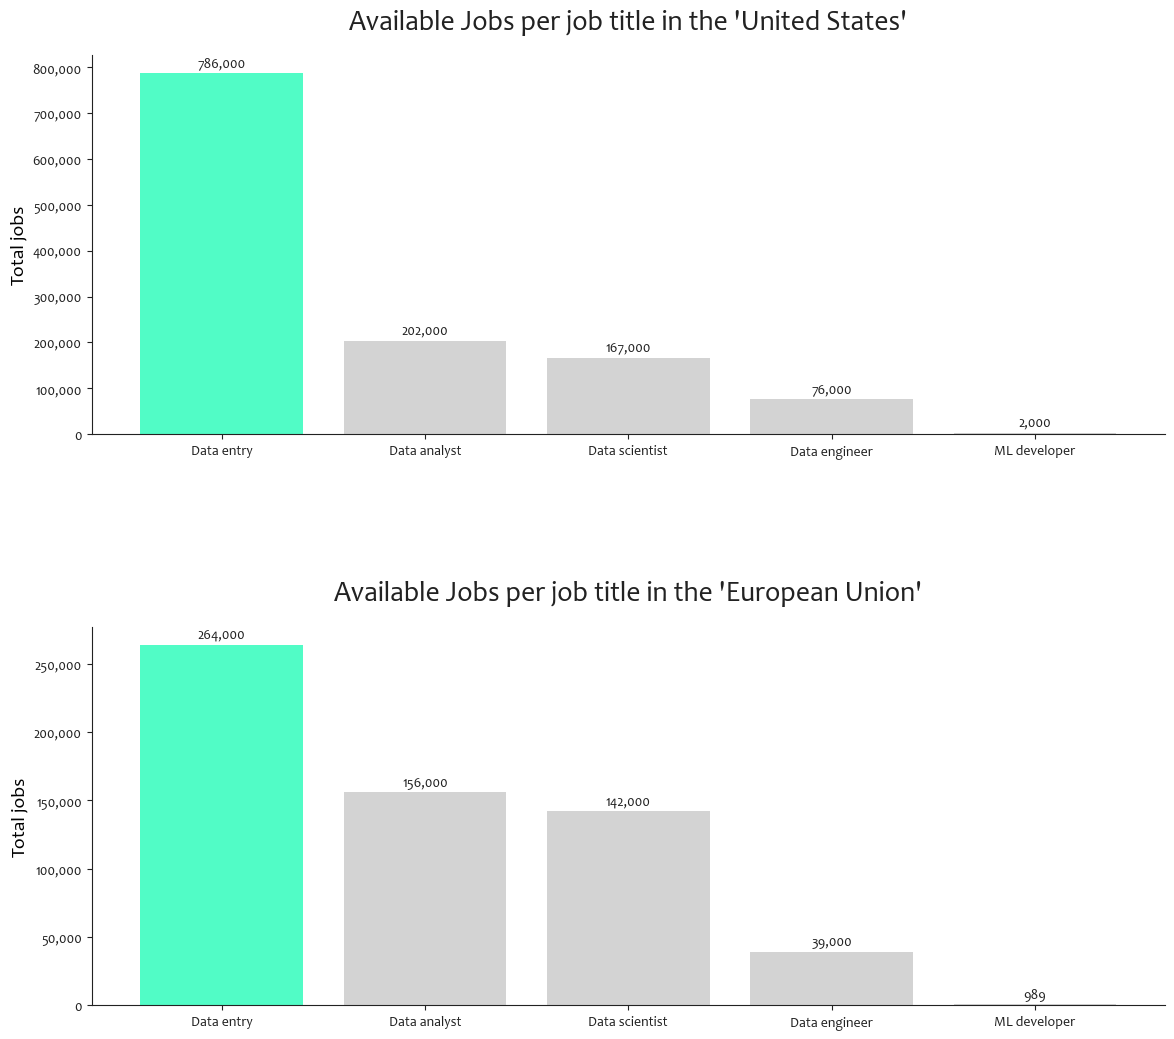

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows= 2)

countries = ['\'United States\'', '\'European Union\'']

colors_temp = [COLORS[0]] * 1
colors_temp += ['lightgrey'] * 5

for ax, country in zip([ax1, ax2], countries):
    
    data = query_pandas(f'''SELECT total_jobs,
                                 job_title,
                                 country
                           FROM linkedin_jobs
                           WHERE country = {country}
                           GROUP BY job_title
                           ORDER BY total_jobs DESC;''')
    
    ax.bar(x=      data['job_title'],
           height= data['total_jobs'],
           color=  colors_temp)
    
    ax.spines[['right', 'top']].set_visible(False)

    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    ax.set_title(f'Available Jobs per job title in the {country}', fontsize= FONT, pad= 19)
    ax.set_ylabel('Total jobs', fontsize= FONT * 3.5/5)
    
    color_spine(ax)
    
    if ax is ax1:
        add_bar_labels(data['job_title'], data['total_jobs'], ax, scaler= 15000)
        
    if ax is ax2:
        add_bar_labels(data['job_title'], data['total_jobs'], ax, scaler= 5000)

        
fig.tight_layout(h_pad=0.5, w_pad=5)
fig.set_size_inches(13, 12)

save_plot(fig, 'available-jobs-per-job-title-and-country')
plt.show()

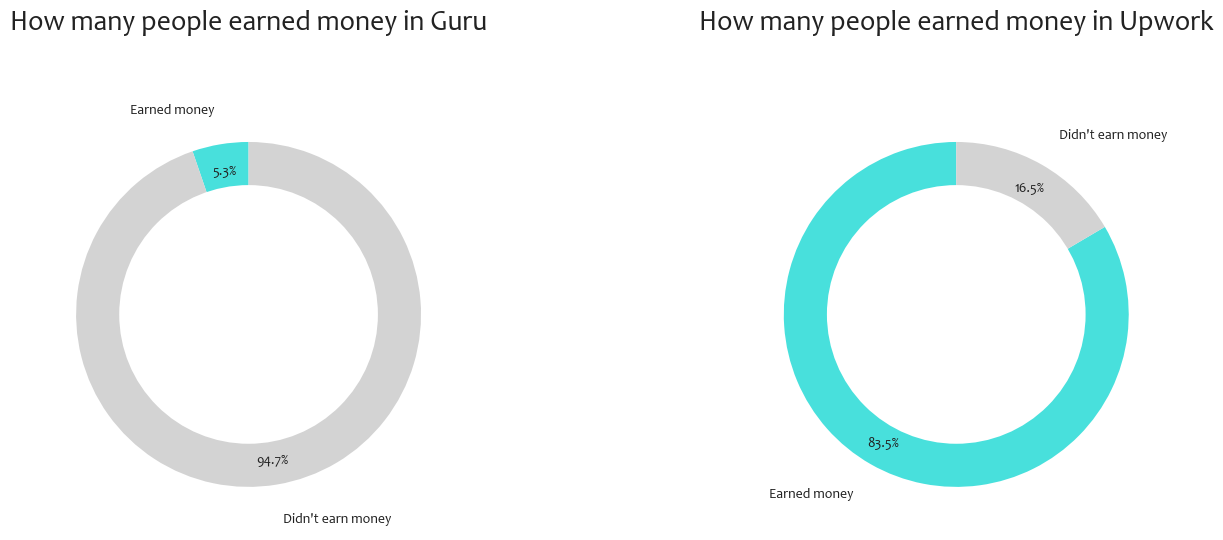

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

platforms   : list = ['guru', 'upwork']
labels      : list = ['Earned money', 'Didn\'t earn money']
colors_temp : list = [COLORS[1], 'lightgrey']
explode     : list = [0.2, 0.2]

for ax, platform in zip([ax1, ax2], platforms):
    # The first row in the queried table below contains the people who have earned money count
    data = query_pandas(f'''SELECT COUNT(*) AS total_profiles
                           FROM {platform}_profiles
                           WHERE earnings_amount_new > 0
                           
                           UNION ALL
                           
                           SELECT COUNT(*) AS total_profiles
                           FROM {platform}_profiles
                           WHERE earnings_amount_new IS NULL OR 
                                 earnings_amount_new = 0;''')

    # Plot the pie chart on the current axis
    # ax.pie(counts, labels=labels, autopct='%2.1f%%', pctdistance=0.85, labeldistance=1.2, colors= colors_temp)
    
    ax.pie(data['total_profiles'], labels=labels, autopct='%2.1f%%',
           pctdistance=0.85, labeldistance=1.2, colors=colors_temp,
           startangle=90)
    
    ax.set_title(f'How many people earned money in {platform.title()}', fontsize= FONT, pad= 50)
                 
    centre_circle = plt.Circle((0, 0), 0.75, fc='white')
    ax.add_artist(centre_circle)

fig.tight_layout(w_pad=7)
fig.set_size_inches(13, 10)

save_plot(fig, 'people-who-earned-money-per-platform-ratio')
plt.show()

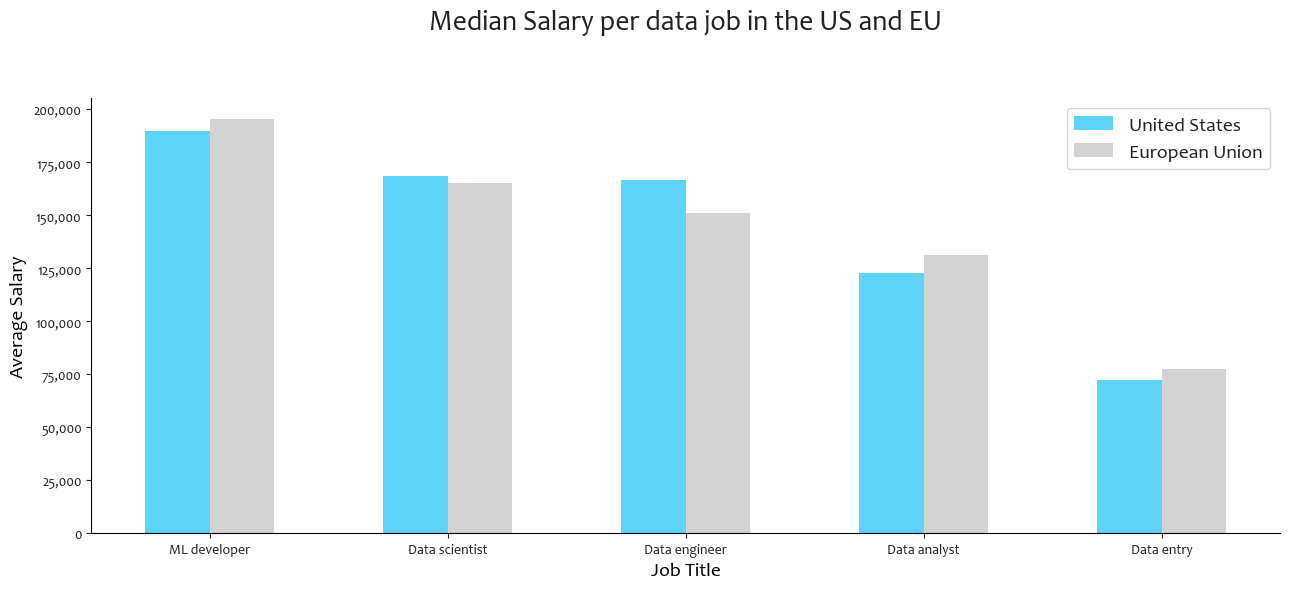

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

width = 0.27

data = query_pandas(f'''SELECT AVG(salary) AS avg_salary,
                               country,
                               job_title

                        FROM linkedin_jobs
                        WHERE salary > 100 
                        GROUP BY country, job_title
                        ORDER BY avg_salary DESC;''')

us_data = data[data['country'] == 'United States']
eu_data = data[data['country'] == 'European Union']

positions_us = range(len(us_data))
positions_eu = [pos + width for pos in positions_us]


ax.bar(positions_us, us_data['avg_salary'], width,
       align='center', label='United States',
       color= COLORS[2])

ax.bar(positions_eu, eu_data['avg_salary'], width,
       align='center', label='European Union',
       color= 'lightgrey')


ax.spines[['right', 'top']].set_visible(False)
ax.set_xticks([pos + width/2 for pos in positions_us])
ax.set_xticklabels(us_data['job_title'], ha='center')

ax.set_title(f'Median Salary per data job in the US and EU', fontsize= FONT, pad= 50)
ax.set_xlabel('Job Title',      fontsize= FONT * 3.5/5)
ax.set_ylabel('Average Salary', fontsize= FONT * 3.5/5)


ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.legend(fontsize='14')
fig.set_size_inches(13, 6)
fig.tight_layout()

save_plot(fig, 'median-salary-per-job-title-and-country')
plt.show()

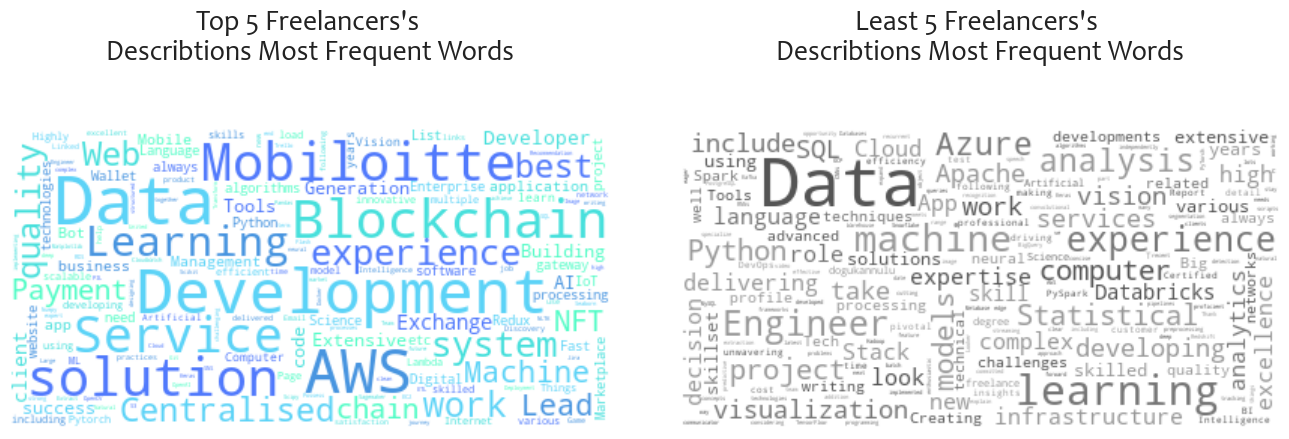

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

cmap      = ListedColormap(COLORS)
grey_cmap = ListedColormap(GREYS)

top_5_describtions = query_pandas('''SELECT describtion
                                     FROM upwork_profiles
                                     WHERE earnings_amount_new IS NOT NULL
                                     ORDER BY earnings_amount_new DESC
                                     LIMIT 5;''')['describtion'].str.cat(sep= ' ')

least_5_describtions = query_pandas('''SELECT describtion
                                       FROM upwork_profiles
                                       WHERE earnings_amount_new IS NOT NULL
                                       ORDER BY earnings_amount_new
                                       LIMIT 5;''')['describtion'].str.cat(sep= ' ')

wordcloud_ax1 = WordCloud(collocations= False, background_color= 'white',
                      max_font_size= 45, colormap= cmap).generate(top_5_describtions)


wordcloud_ax2 = WordCloud(collocations= False, background_color= 'white',
                      max_font_size= 45, colormap= grey_cmap).generate(least_5_describtions)

ax1.set_title(f'Top 5 Freelancers\'s \nDescribtions Most Frequent Words', fontsize= FONT, pad= 50)
ax2.set_title(f'Least 5 Freelancers\'s \nDescribtions Most Frequent Words', fontsize= FONT, pad= 50)

ax1.imshow(wordcloud_ax1, interpolation='bilinear')
ax1.axis('off')

ax2.imshow(wordcloud_ax2, interpolation='bilinear')
ax2.axis('off')

fig.set_size_inches(13, 6)
plt.tight_layout(w_pad= 5)

save_plot(fig, 'top-and-least-5-freelancers-describtions-wordcloud')
plt.show()

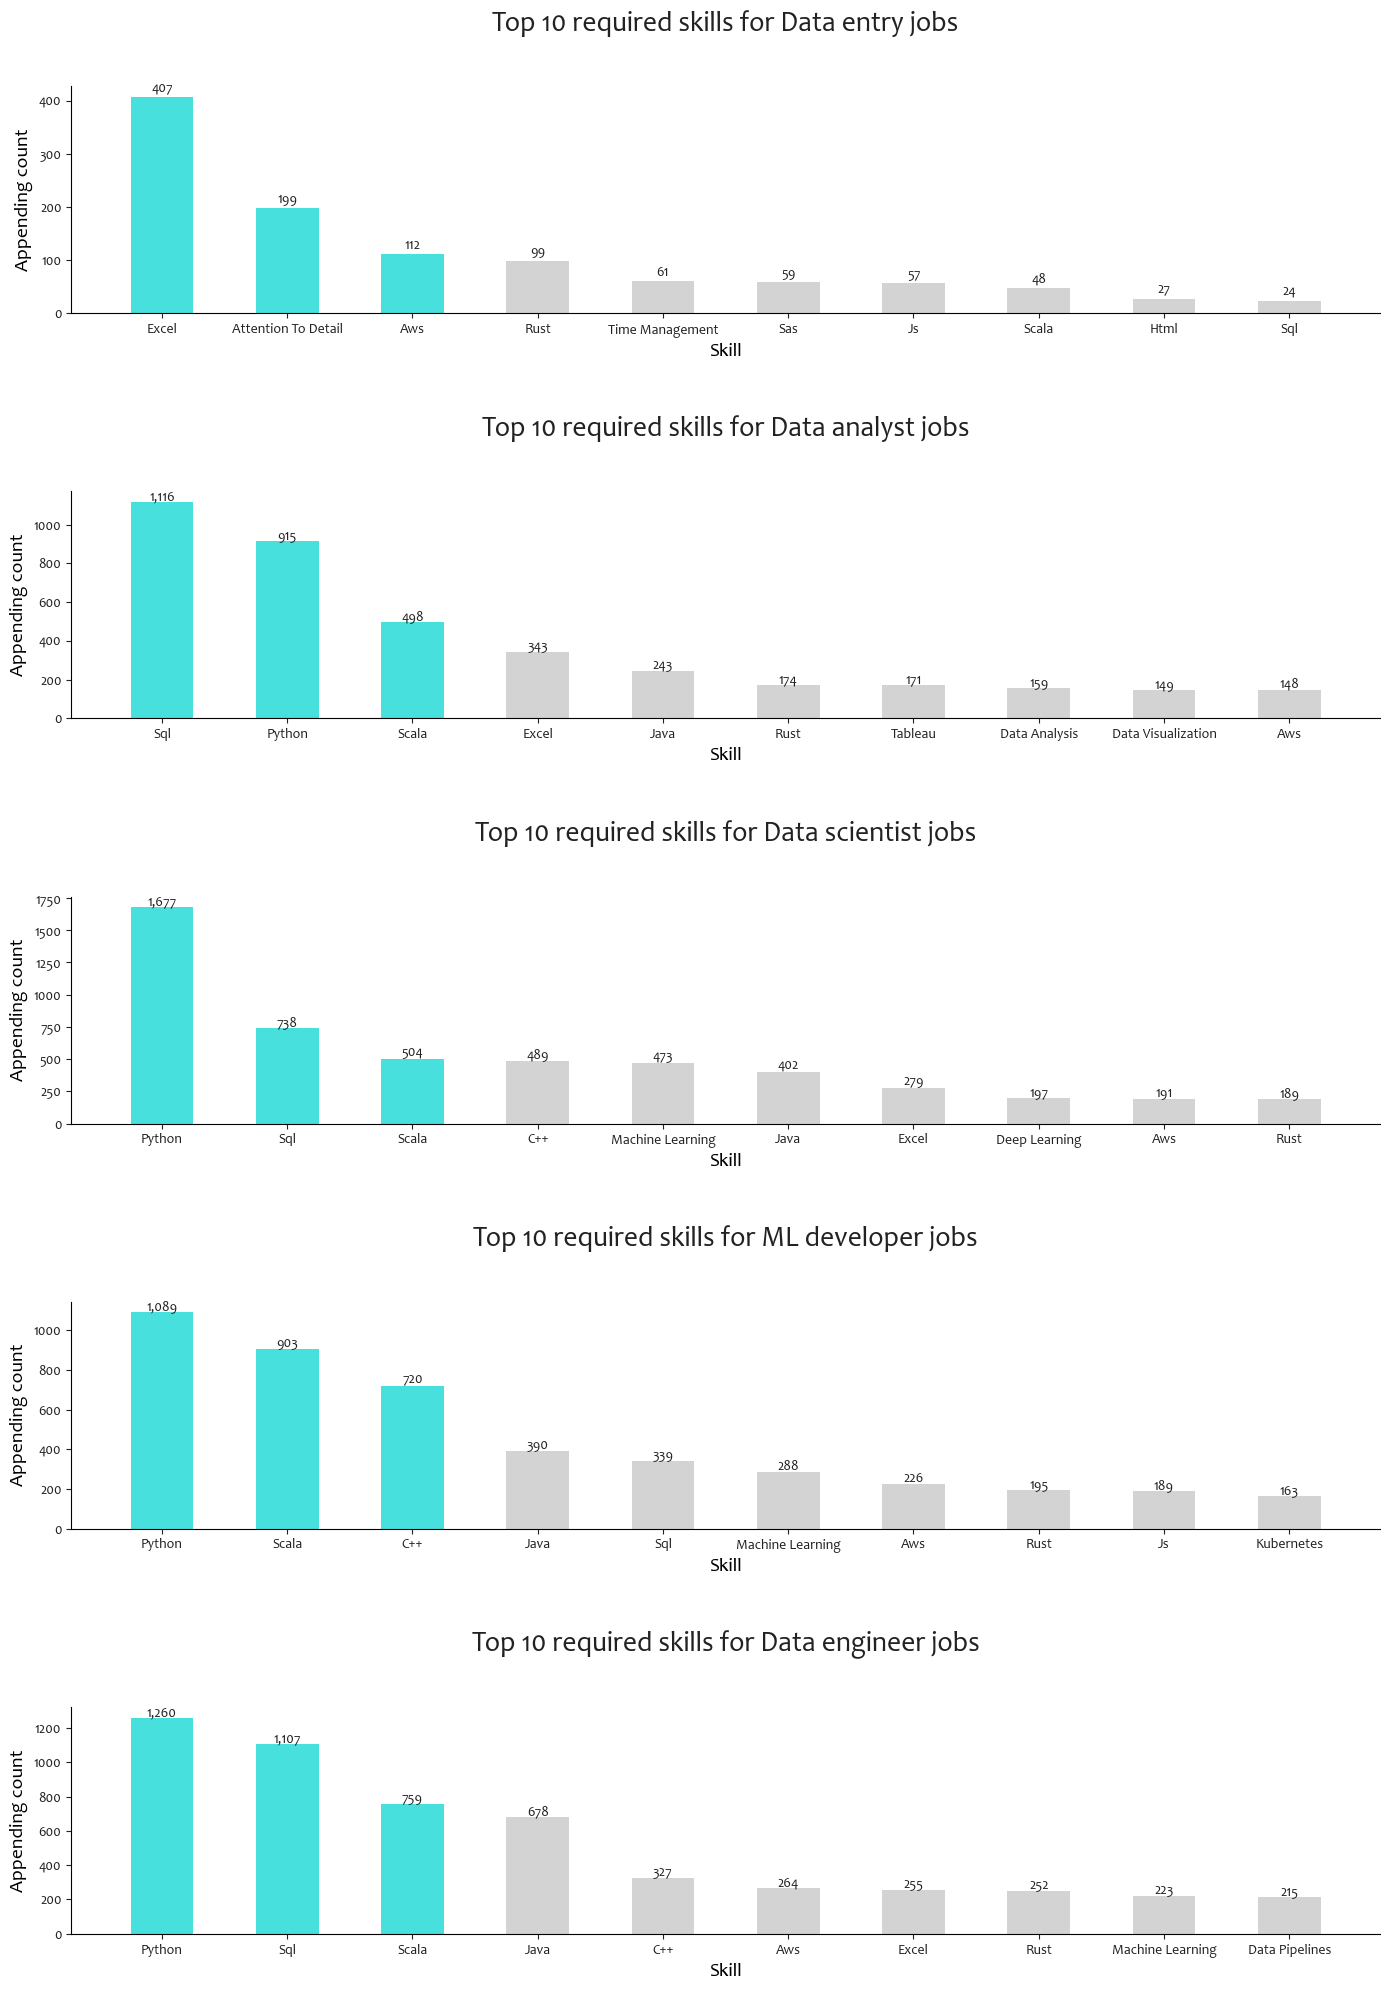

In [16]:
fig, axes = plt.subplots(nrows=5)
width = 0.5

colors_temp = [COLORS[1]] * 3
colors_temp += ['lightgrey']* 7

for i, job_title in enumerate(linkedin_jobs['job_title'].unique()):

    skills_count = dict(Counter(np.concatenate(linkedin_jobs[
                           (linkedin_jobs['job_title'] == job_title)].reset_index()['skills'])))

    top_10_skills_count = {k: v for k, v in sorted(skills_count.items(), key=lambda item: item[1], reverse=True)[:10]}

    labels = [key.title() for key in top_10_skills_count.keys()]  # Formatting the strings
    values = list(top_10_skills_count.values())

    axes[i].bar(range(len(labels)), values, width,
                align='center', color= colors_temp)

    if i != 2:
        add_bar_labels(labels, values, axes[i], scaler= 10)
    else:
        add_bar_labels(labels, values, axes[i], scaler= 20)

    axes[i].spines[['right', 'top']].set_visible(False)
    axes[i].set_xticks(range(len(labels)))
    axes[i].set_xticklabels(labels, ha='center')

    axes[i].set_title(f'Top 10 required skills for {job_title} jobs', fontsize=FONT, pad=40)
    axes[i].set_xlabel('Skill', fontsize=FONT * 3.5 / 5)
    axes[i].set_ylabel('Appending count', fontsize=FONT * 3.5/5)


fig.set_size_inches(h=20, w=14)
fig.tight_layout(h_pad= 4)

save_plot(fig, 'top-10-appending-skills-per-job-title')
plt.show()

Found 23 outliers from 317 length series!


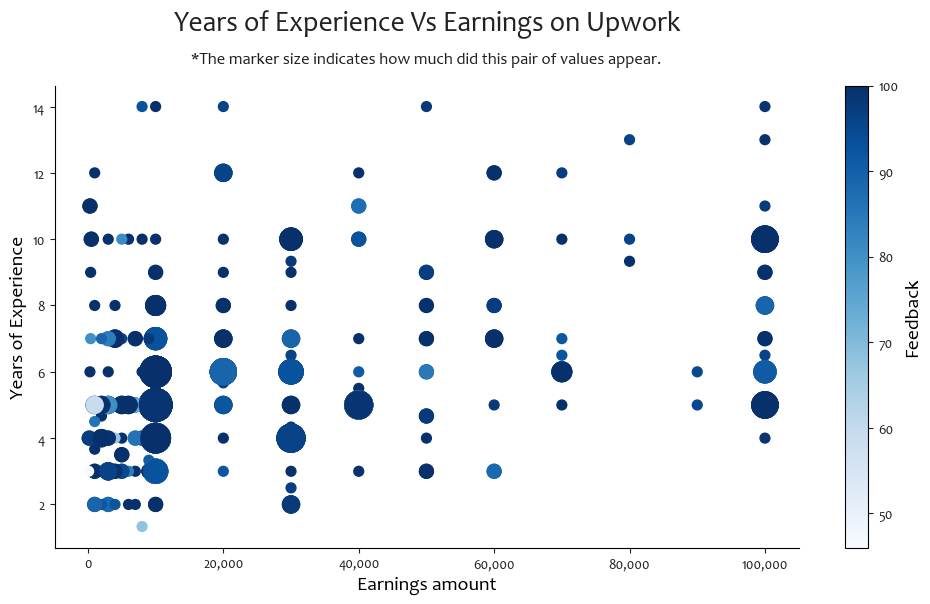

In [19]:
cm = plt.cm.Blues

data = upwork_profiles[['earnings_amount_new', 'exp_years', 'feedback']].dropna().reset_index()
outliers = tucky_method(data['earnings_amount_new'].to_numpy())
outliers_indexes = np.array(*np.where(np.isin(data['earnings_amount_new'], outliers)))
data = data.drop(outliers_indexes).drop(['index'], axis=1)


pair_freq = {}
for earnings, exp_years in zip(data['earnings_amount_new'], data['exp_years']):
    pair = (earnings, exp_years)
    pair_freq[pair] = pair_freq.get(pair, 0) + 1


marker_sizes = [50 * pair_freq[(earnings, exp_years)] for earnings, exp_years in zip(data['earnings_amount_new'], data['exp_years'])]

fig, ax = plt.subplots()
scatter = ax.scatter(data['earnings_amount_new'], data['exp_years'], c=data['feedback'], cmap=cm, s=marker_sizes)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.text(50000, 15.3, '*The marker size indicates how much did this pair of values appear.', ha='center', fontsize=12)
ax.set_title('Years of Experience Vs Earnings on Upwork', fontsize=FONT, pad=40)
ax.set_xlabel('Earnings amount', fontsize=FONT * 3.5 / 5)
ax.set_ylabel('Years of Experience', fontsize=FONT * 3.5 / 5)

fig.set_size_inches(w=12, h=6)

# Show the colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Feedback', fontsize=FONT * 3.5 / 5)

save_plot(fig, 'exp-years-vs-earnings')
plt.show()

Now we will create a **`spearman correlation cofficient heatmap`** to see our correlations more clear.

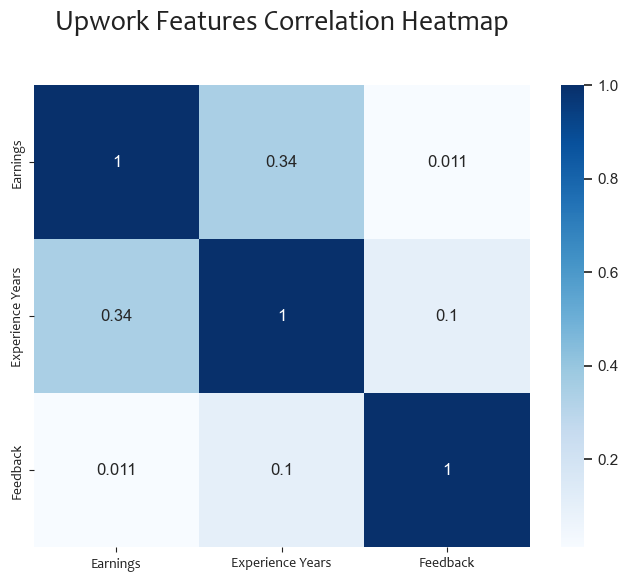

In [90]:
fig, ax = plt.subplots()

sns.set(font_scale=1)

data.rename({'earnings_amount_new': 'Earnings',
             'exp_years': 'Experience Years',
             'feedback': 'Feedback'}, axis= 1, inplace= True)

corr = data.corr(method= 'spearman')

g = sns.heatmap(corr, cmap= 'Blues', annot=True, ax= ax)

ax.set_title('Upwork Features Correlation Heatmap', fontsize= FONT, pad= 40)

fig.set_size_inches(8, 6)

save_plot(fig, 'upwork-features-corr-heatmap')
plt.show()

## <center><strong><span style= 'color: #4895e0'>Visualizing</span> the data (part 2)

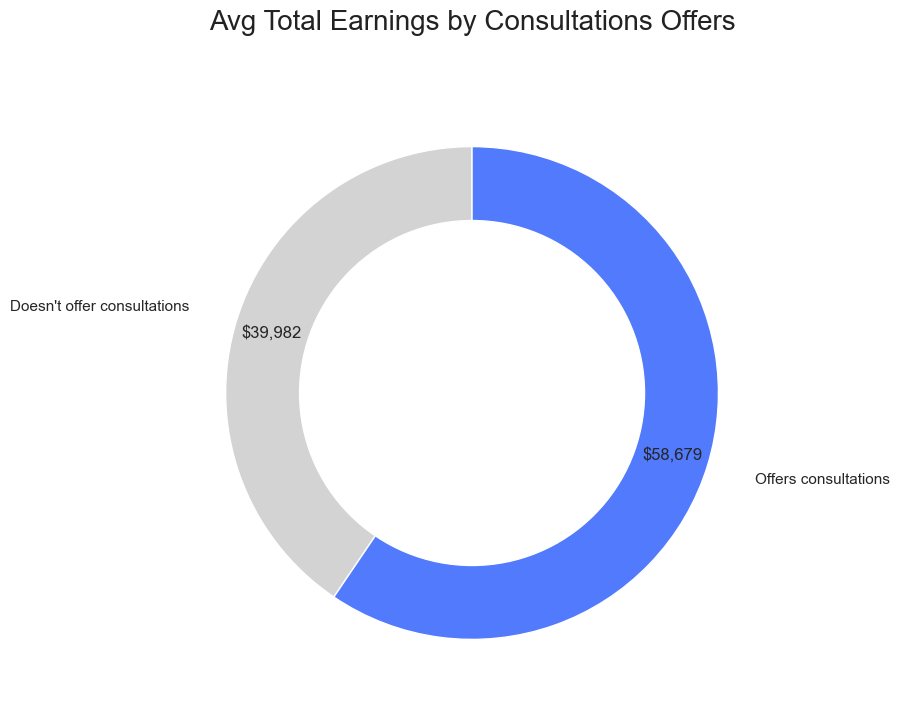

In [91]:
fig, ax = plt.subplots()

data = query_pandas('''SELECT AVG(earnings_amount_new) AS 'Total earnings',
                              consultations_offers AS 'Consultations offers'

                       FROM upwork_profiles

                       -- To get out of outliers
                       WHERE earnings_amount_new < 800000 -- 800K
                       GROUP BY consultations_offers''')

values = data['Total earnings']
labels = data['Consultations offers']

def format_label(value):

    index = int(value/100. * len(values))
    
    return f'${int(values[index]):,}'


temp_colors = ['lightgrey', COLORS[4]]
ax.pie(values, labels= labels, autopct=format_label, colors=temp_colors,
       pctdistance=0.85, labeldistance=1.2, startangle=90)

centre_circle = plt.Circle((0, 0), 0.7, fc='white')
ax.add_artist(centre_circle)


# ax.set_title('Pie Chart of Total Earnings by Consultations Offers')
ax.set_title('Avg Total Earnings by Consultations Offers', fontsize= FONT, pad= 40)

fig.set_size_inches(8,8)

save_plot(fig, 'earnings-vs-offering-consultation')
plt.show()

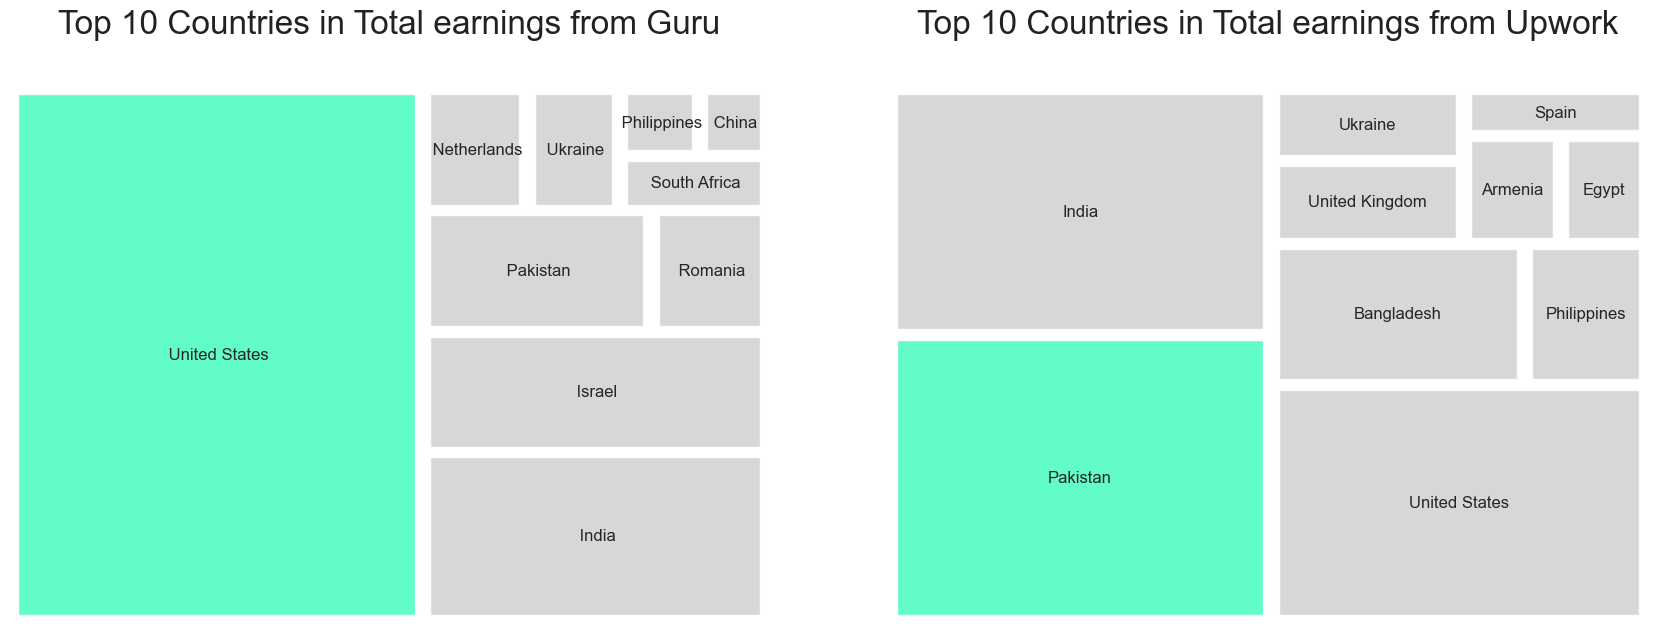

In [92]:
fig, axes = plt.subplots(ncols=2)

for ax in axes:
    ax.axis('off')

for i, platform_name in enumerate(['guru', 'upwork']):

    if platform_name == 'guru':
        top_10_countries = query_pandas(f'''SELECT 
                                           country,
                                           SUM(earnings_amount_new) AS total_earnings
                                       FROM {platform_name}_profiles
                                       WHERE earnings_amount_new < 800000 -- 800K
                                       GROUP BY country
                                       ORDER BY total_earnings DESC
                                       LIMIT 10;
                                       ''')

    elif platform_name == 'upwork':
        top_10_countries = query_pandas(f'''SELECT country,
                                                   SUM(earnings_amount_new) AS total_earnings
                                               FROM {platform_name}_profiles
                                               WHERE earnings_amount_new < 800000 -- 800K
                                               GROUP BY country
                                               ORDER BY total_earnings DESC
                                               LIMIT 10;
                                               ''')

    sizes = top_10_countries['total_earnings'].values
    labels = top_10_countries['country'].values

    colors_temp = [*[COLORS[0]] * 1, *['lightgrey'] * 9]

    squarify.plot(sizes=sizes, label=labels, alpha=0.9,
                  color=colors_temp, ax=axes[i], pad=True)

    axes[i].set_title(
        f'Top 10 Countries in Total earnings from {platform_name.title()}', fontsize=FONT* 1.2, pad=40) 

plt.tight_layout()
fig.set_size_inches(w=18, h=7)

save_plot(fig, 'top-10-countries-in-total-earnings-per-platform')
plt.show()

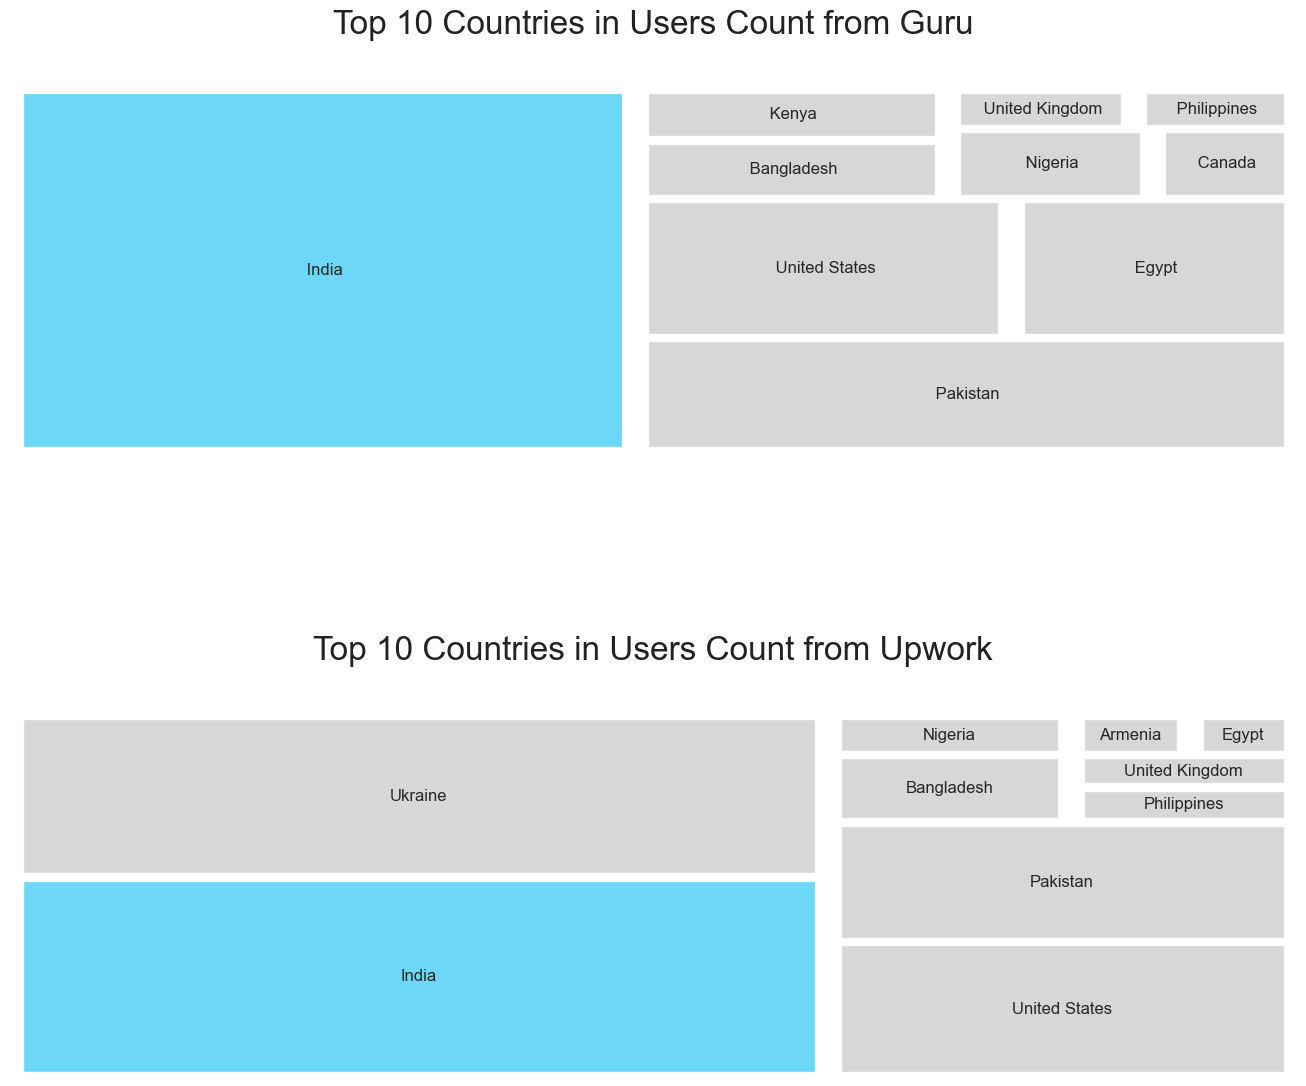

In [93]:
fig, axes = plt.subplots(nrows=2)

for ax in axes:
    ax.axis('off')

for i, platform_name in enumerate(['guru', 'upwork']):

    if platform_name == 'guru':
        top_10_countries = query_pandas(f'''SELECT 
                                           country,
                                           COUNT(*) AS total_users
                                       FROM {platform_name}_profiles
                                       GROUP BY country
                                       ORDER BY total_users DESC
                                       LIMIT 10;
                                       ''')

    elif platform_name == 'upwork':
        top_10_countries = query_pandas(f'''SELECT country,
                                                   SUM(earnings_amount_new) AS total_users
                                               FROM {platform_name}_profiles
                                               GROUP BY country
                                               ORDER BY total_users DESC
                                               LIMIT 10;
                                               ''')

    sizes   = top_10_countries['total_users'].values
    labels  = top_10_countries['country'].values

    colors_temp = [*[COLORS[2]] * 1, *['lightgrey'] * 9]

    squarify.plot(sizes= sizes, label= labels, alpha= 0.9,
                  color= colors_temp, ax= axes[i], pad= True)

    axes[i].set_title(f'Top 10 Countries in Users Count from {platform_name.title()}', fontsize=FONT* 1.2, pad=40) 

plt.tight_layout()
fig.set_size_inches(w=14, h=13)

save_plot(fig, 'top-10-countries-in-users-count-per-platform')
plt.show()

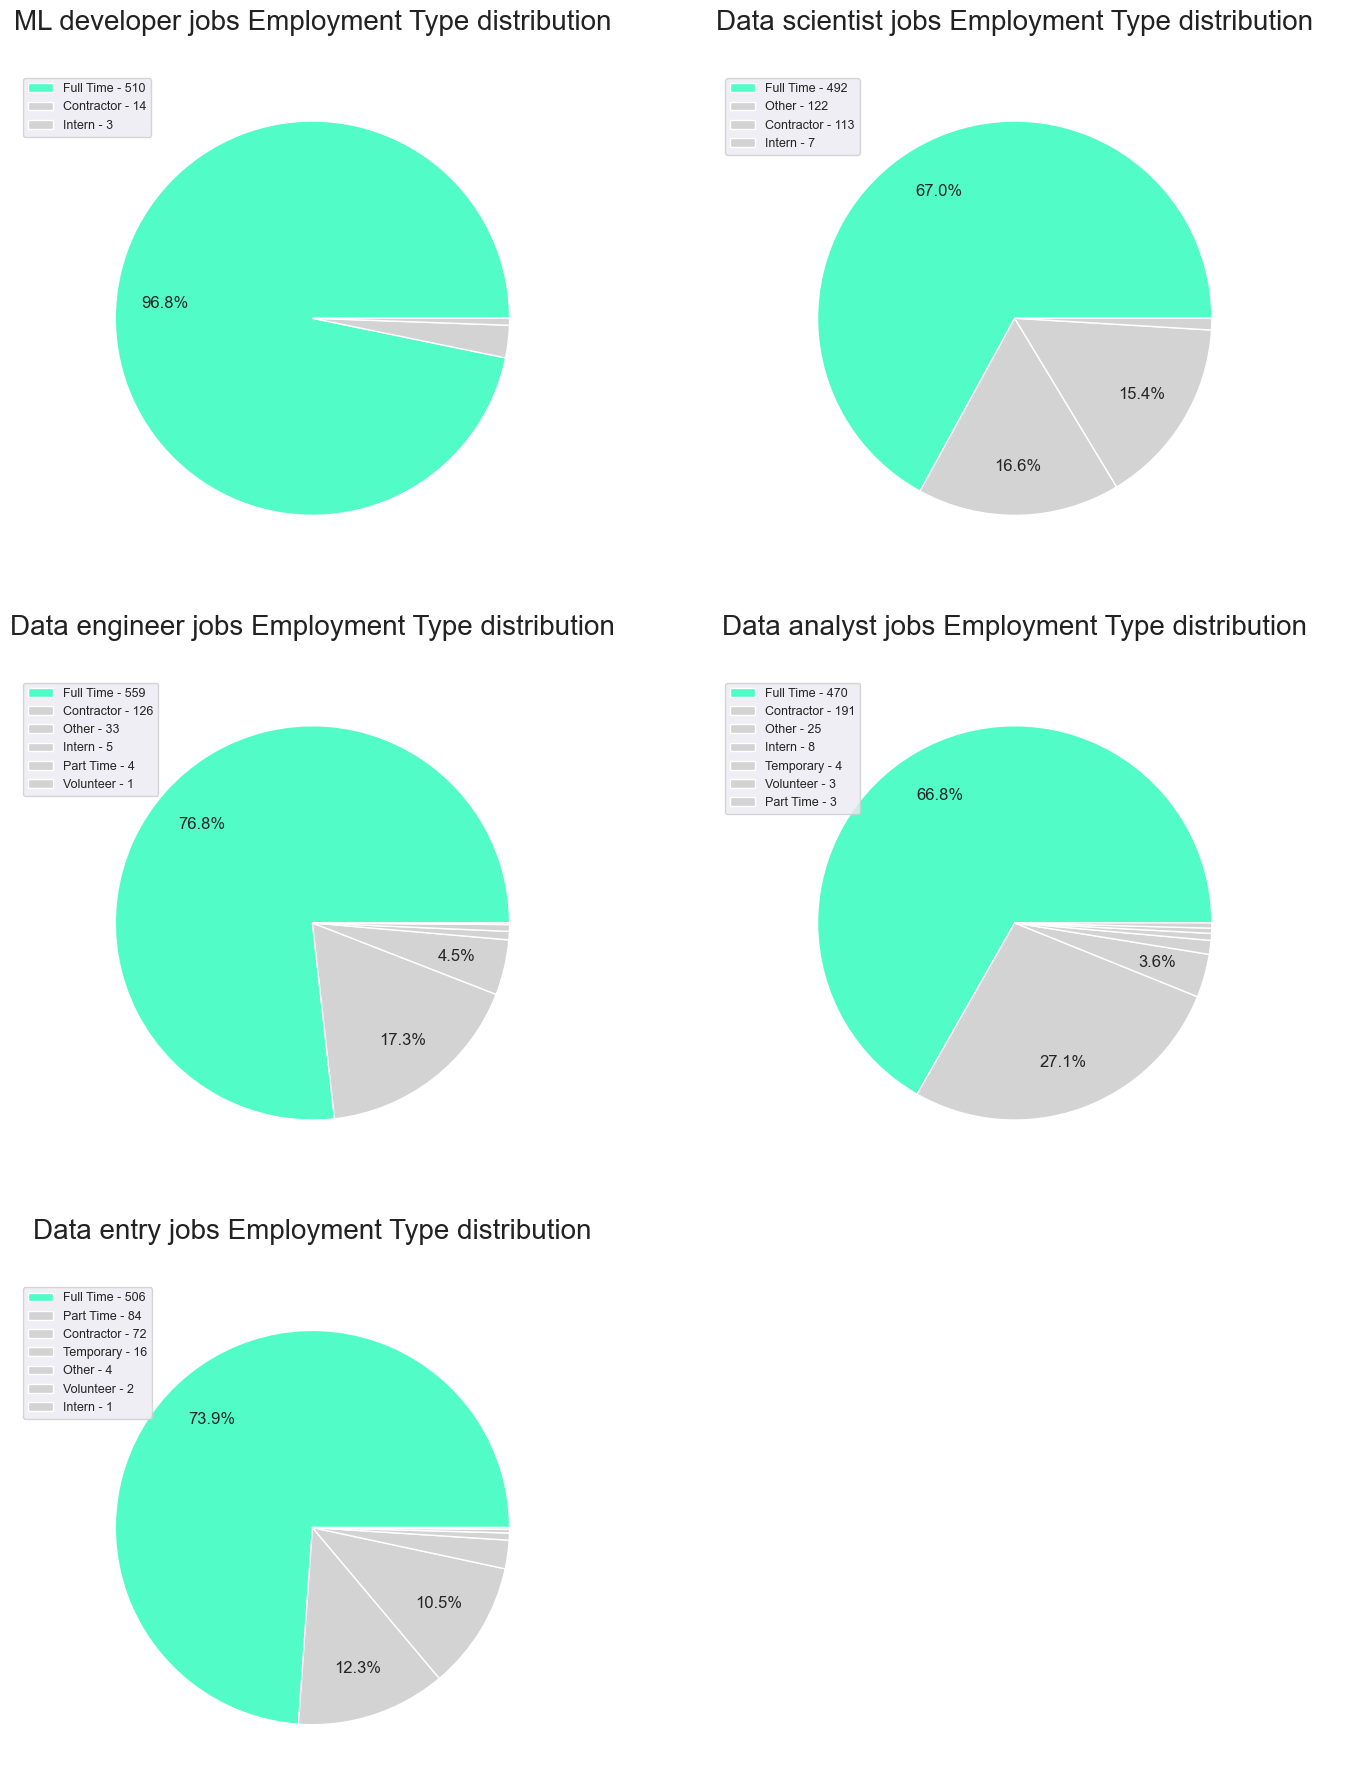

In [94]:
unique_job_titles = linkedin_jobs['job_title'].unique()
num_plots         = len(unique_job_titles)

fig, axes = plt.subplots(3, 2, figsize=(14, 18))
axes = axes.flatten()

for i, job_title in enumerate(unique_job_titles):
    data = query_pandas(f'''SELECT COUNT(*) AS total_jobs,
                                   employment_type
                                   
                            FROM linkedin_jobs
                            WHERE job_title= '{job_title}'
                            GROUP BY employment_type
                            
                            ORDER BY total_jobs DESC''')
    
    data['employment_type'] = data['employment_type'].apply(lambda x: x.title().replace('_', ' '))
    
    colors = [COLORS[0], * ['lightgrey'] * (len(data) + 1)]
    
    values = data['total_jobs']
    labels = ['{0} - {1:1.0f}'.format(i,j) for i,j in zip(data['employment_type'], values)]
    
    
    autopct     = lambda pct: '{:1.1f}%'.format(pct) if pct > 3 else ''
    wedgeprops  = {'linewidth': 1, 'edgecolor': 'white'}
    
    patches, texts, _ = axes[i].pie(values, colors=colors, autopct= autopct,
                                 pctdistance= 0.75, wedgeprops= wedgeprops)
    
    axes[i].set_title(f'{job_title} jobs Employment Type distribution', fontsize= FONT, pad= 30)
    
    
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, values),
                                      key=lambda x: x[2],
                                      reverse=True))

    axes[i].legend(patches, labels, loc='upper left', bbox_to_anchor=(-0.1, 1.),
               fontsize= FONT * .45)

for i in range(5, 3 * 2):
    axes[i].axis('off')

plt.tight_layout(w_pad= 5, h_pad= 3)

save_plot(fig, 'employment-type-count-distribution')
plt.show()

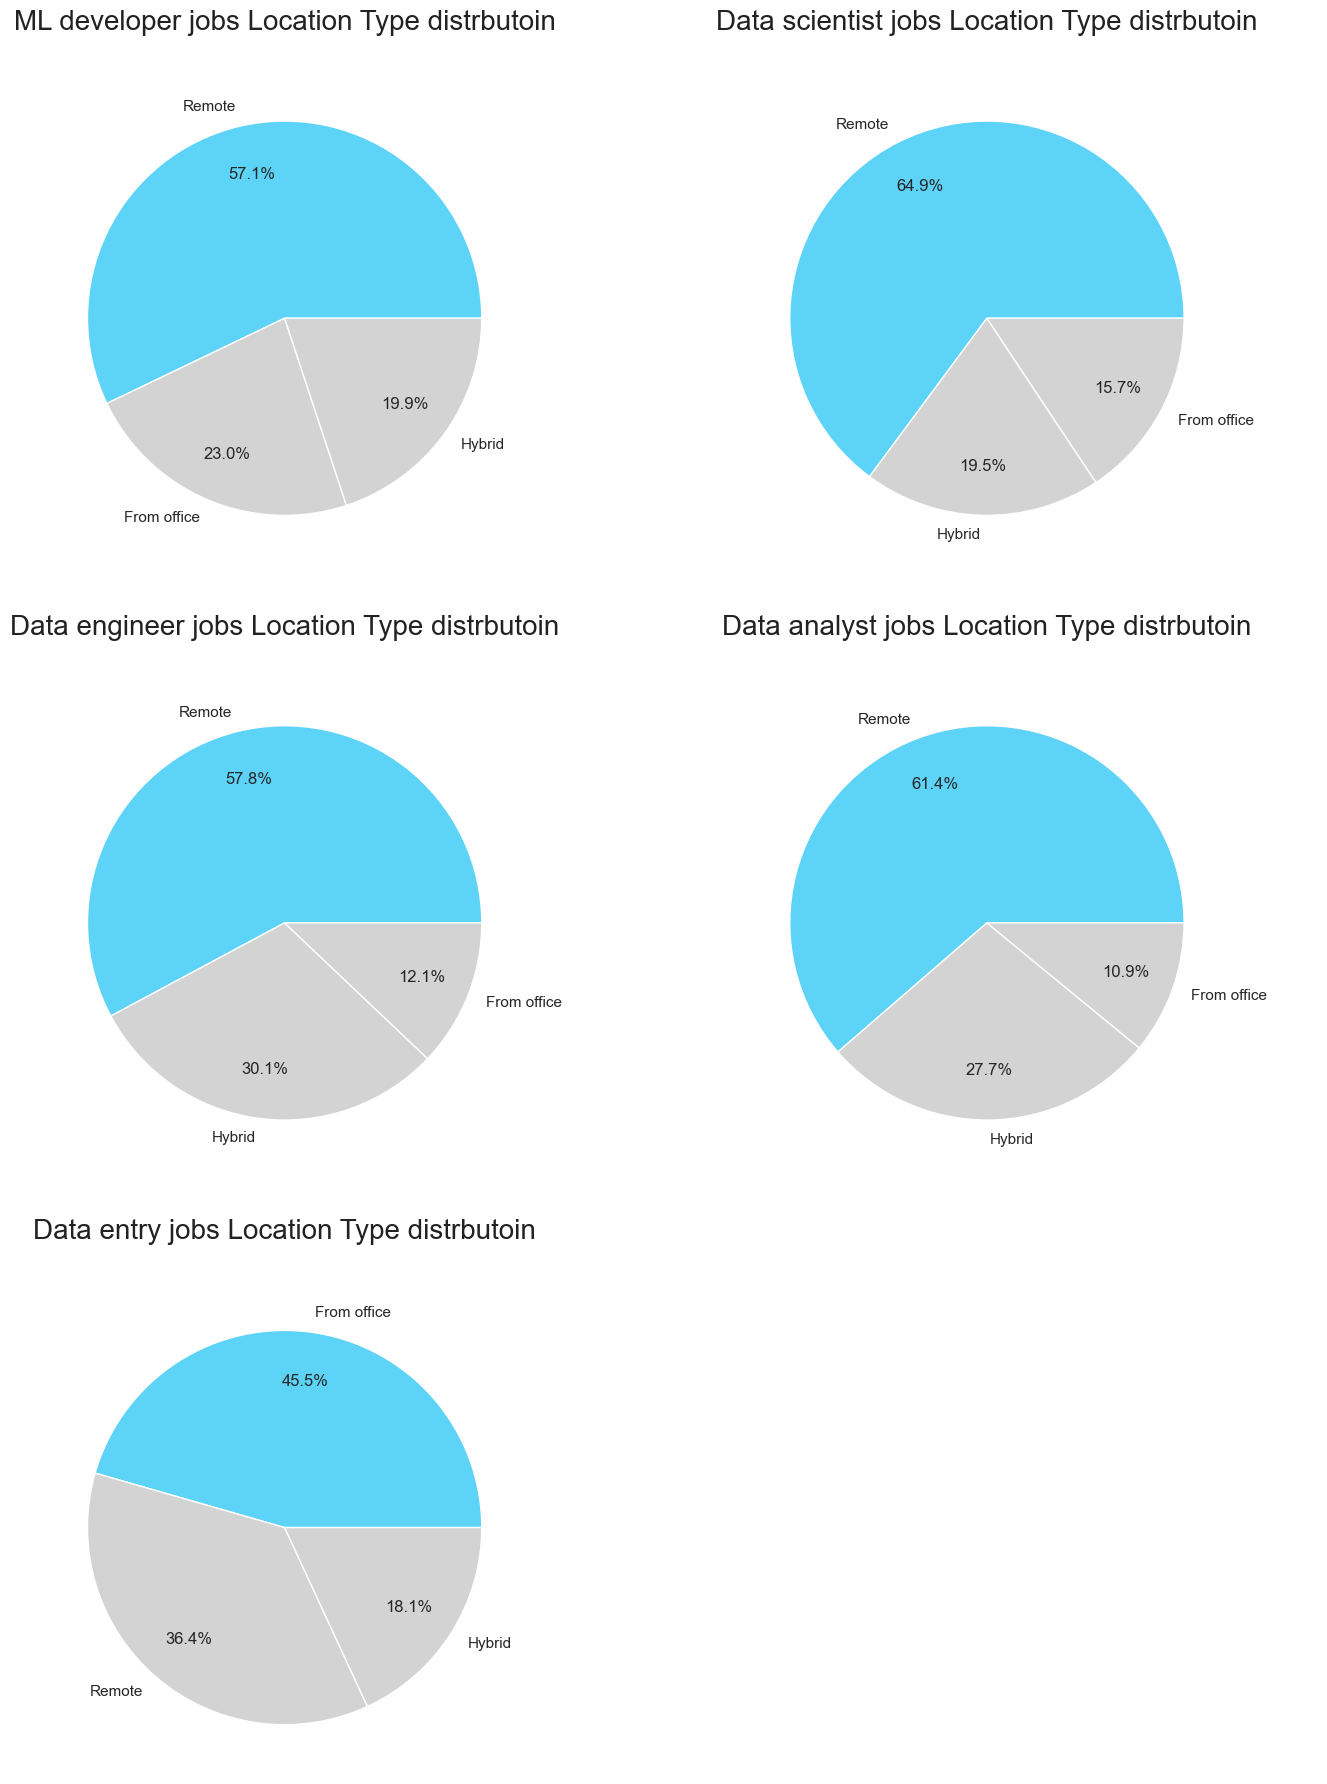

In [95]:
unique_job_titles = linkedin_jobs['job_title'].unique()
num_plots         = len(unique_job_titles)

fig, axes = plt.subplots(3, 2, figsize=(14, 18))
axes = axes.flatten()

for i, job_title in enumerate(unique_job_titles):
    data = query_pandas(f'''SELECT COUNT(*) AS total_jobs,
                                   location_type
                                   
                            FROM linkedin_jobs
                            WHERE job_title= '{job_title}'
                            GROUP BY location_type
                            
                            ORDER BY total_jobs DESC''')

    colors = [COLORS[2], * ['lightgrey'] * (len(data) + 1)]
    
    values = data['total_jobs']
    labels = data['location_type']
    
    
    autopct     = lambda pct: '{:1.1f}%'.format(pct) if pct > 3 else ''
    wedgeprops  = {'linewidth': 1, 'edgecolor': 'white'}
    
    axes[i].pie(values, labels= labels, colors=colors, autopct= autopct,
                pctdistance= 0.75, wedgeprops= wedgeprops)

    axes[i].set_title(f'{job_title} jobs Location Type distrbutoin', fontsize= FONT, pad= 30)

for i in range(5, 3 * 2):
    axes[i].axis('off')

plt.tight_layout(w_pad= 5, h_pad= 3)

save_plot(fig, 'location-type-count-distribution')
plt.show()

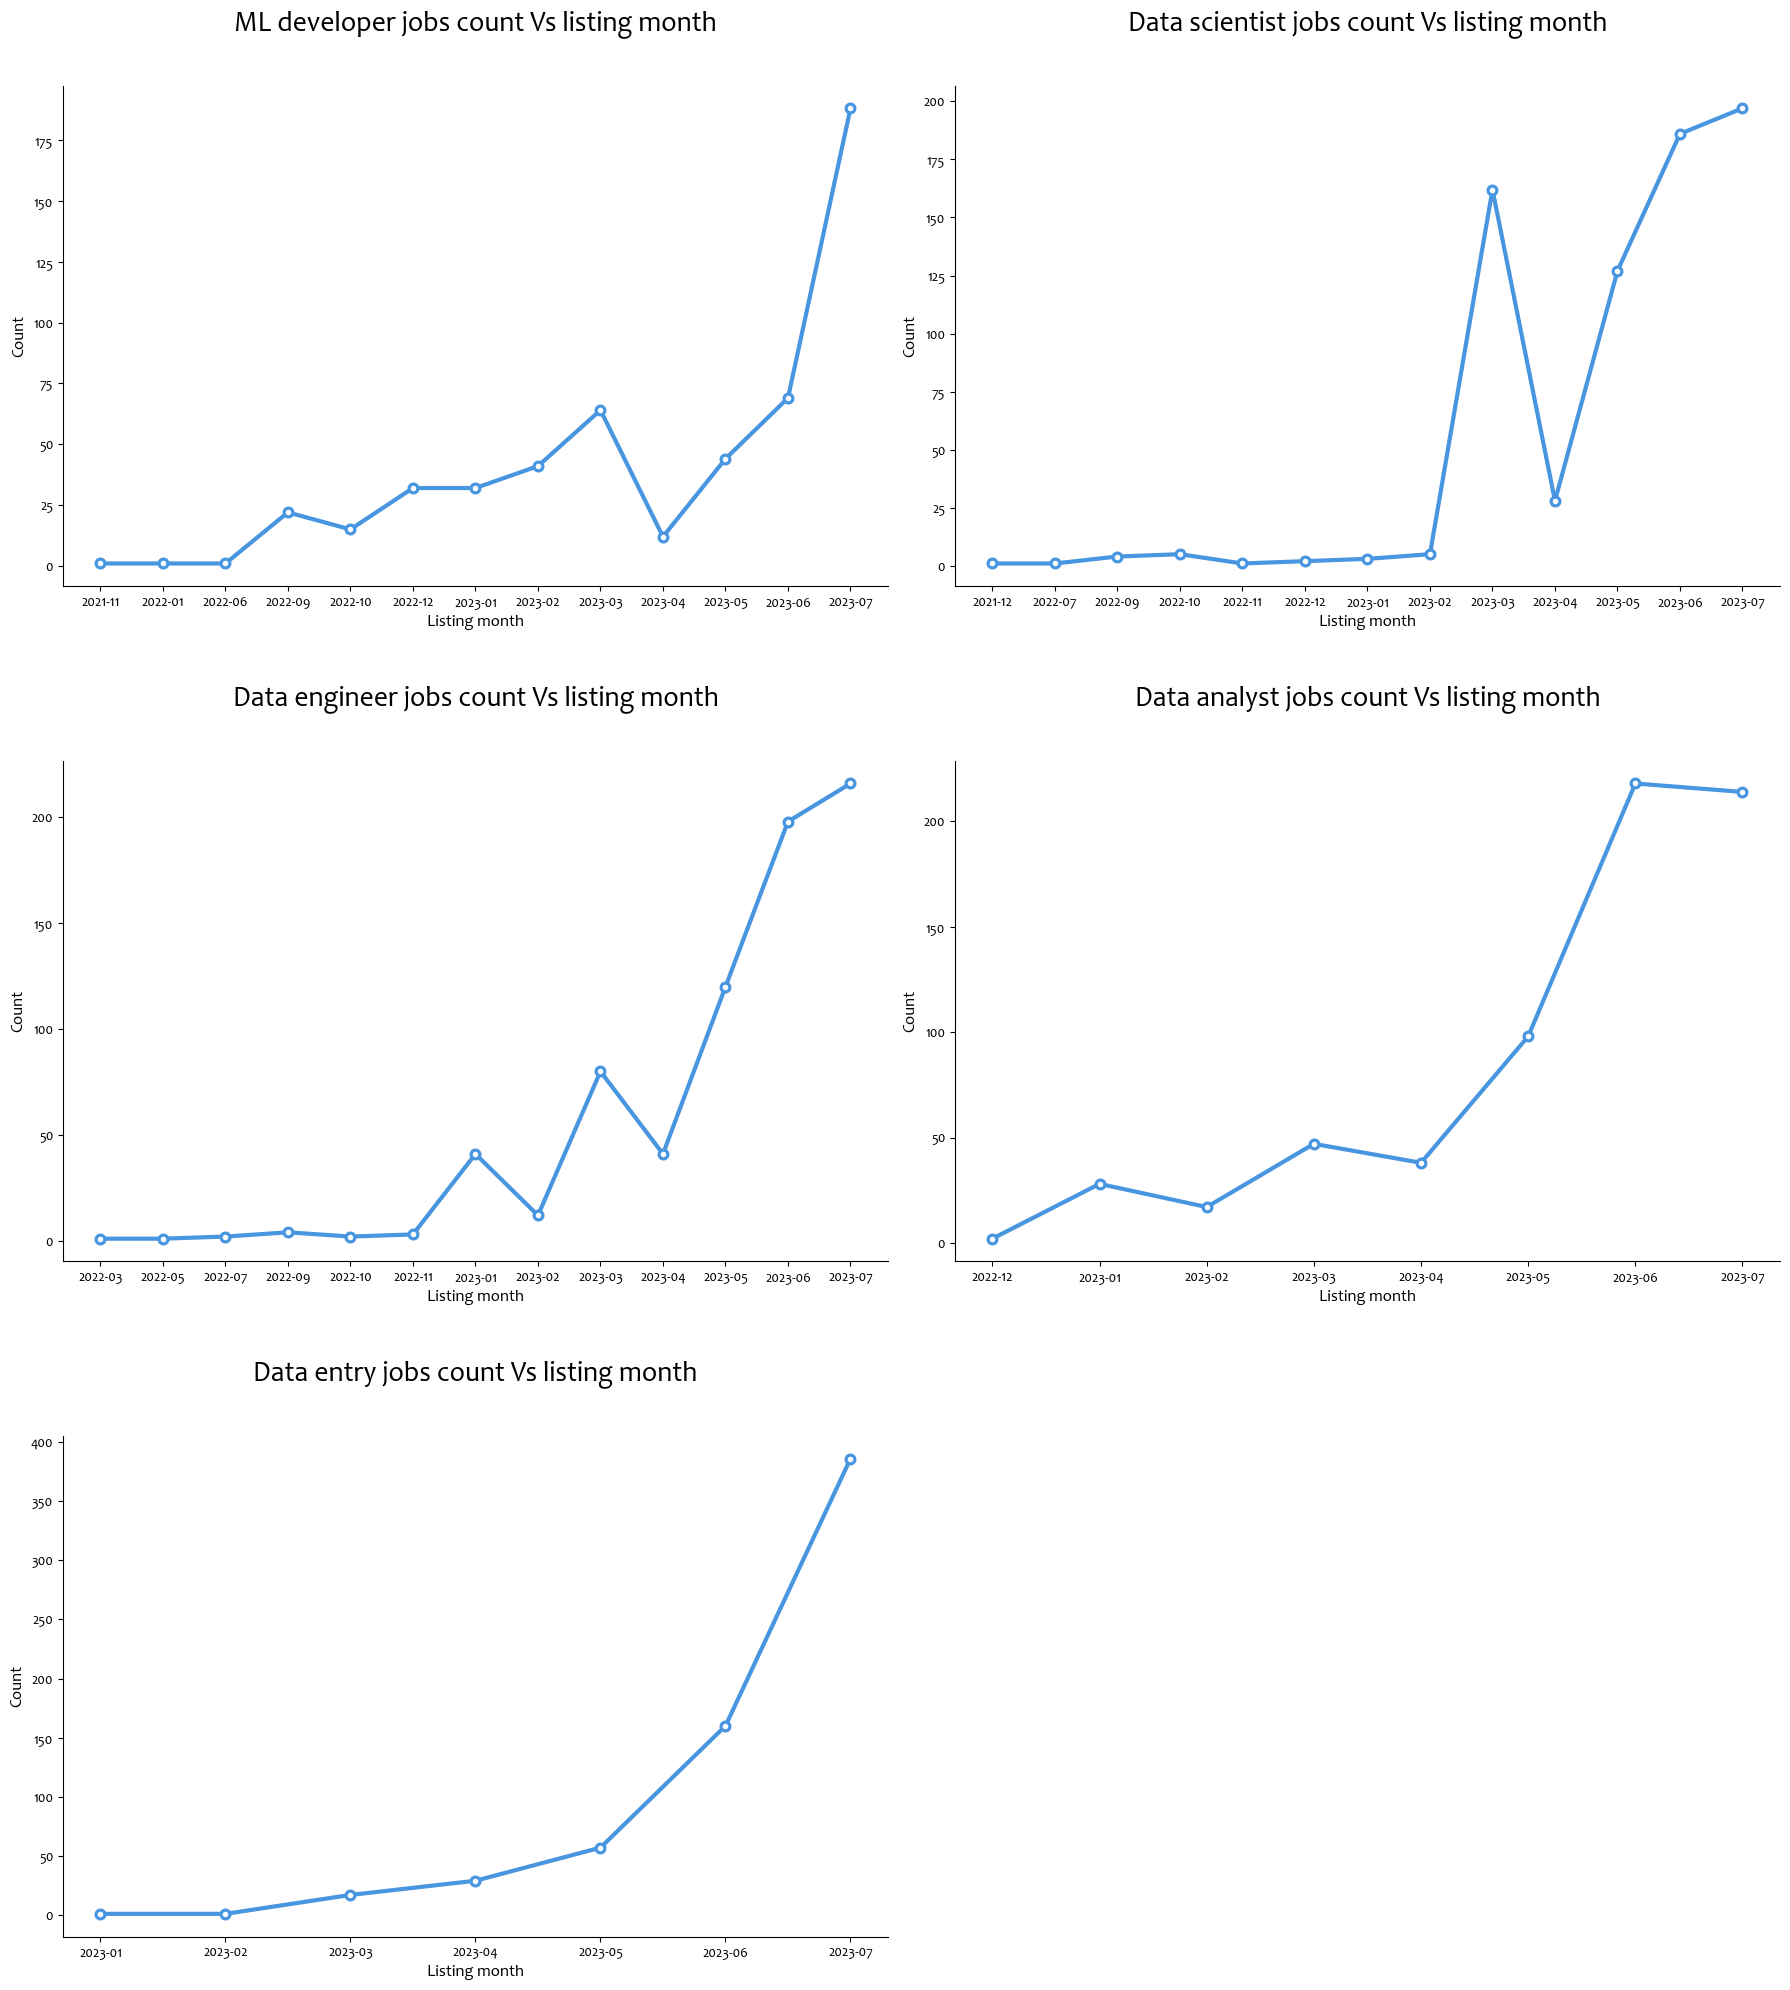

In [97]:
fig, axes = plt.subplots(3, 2)
axes = axes.flatten()


for i, job_title in enumerate(linkedin_jobs['job_title'].unique()):
    
    job_title_data = linkedin_jobs.groupby(
                        linkedin_jobs[linkedin_jobs['job_title'] == job_title][
                            'listing_dates'].dt.to_period('M')).size().reset_index(name='count')
    
    x = job_title_data['listing_dates'].astype(str)
    y = job_title_data['count']
    
    axes[i].plot(x, y, color= COLORS[3], lw=3.0, zorder=10)
    axes[i].scatter(x, y, fc='w', ec= COLORS[3], s=40, lw=2.3, zorder=12)


    axes[i].set_title(f'{job_title} jobs count Vs listing month', fontsize= FONT, pad= 40)
    axes[i].set_ylabel(f'Count', fontsize= FONT*3/5)
    axes[i].set_xlabel(f'Listing month', fontsize= FONT*3/5)
    
    axes[i].spines[['right', 'top']].set_visible(False)
    

axes[5].axis('off')

fig.set_size_inches(w=18, h=20)
plt.tight_layout(h_pad= 4)

save_plot(fig, 'jobs-count-per-listing-month-per-job-title')
plt.show()

## <center><strong><span style= 'color: #517afc'>Saving</span> the data for the app

In [79]:
dataframes = {
    'linkedin_jobs'   : linkedin_jobs,
    'guru_profiles'   : guru_profiles,
    'upwork_profiles' : upwork_profiles}

for table_name, df in dataframes.items():

    table_id   = f'{project_id}.{dataset_id}.{table_name}'

    job_config = bigquery.LoadJobConfig(write_disposition= 'WRITE_TRUNCATE')
    job        = client.load_table_from_dataframe(df, table_id, job_config=job_config)

    job.result()
    print(f'DataFrame \'{table_name}\' uploaded as table \'{table_id}\' in BigQuery.')


KeyboardInterrupt



In [20]:
encrypt.encrypt_json_file('../credentials.json')